In [2]:
import h5py
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
filename = "/Users/forero/Illustris_data/TNG300-1/groups_099/rL205n2500TNG_Subhalo_3DStellarMasses_099.hdf5"
f = h5py.File(filename, 'r')
keys = list(f.keys())
print(keys)
print(list(f['Subhalo']))
#rescaled_stellar_mass = f['Subhalo/StellarMasses_in_Rad'][...]
rescaled_stellar_mass = f['Subhalo/StellarMasses_in_r10pkpc'][...]
done_field = f['Subhalo/Done'][...]
f.close()

['Header', 'Subhalo']
['Done', 'StellarMasses_in_HalfRad', 'StellarMasses_in_Rad', 'StellarMasses_in_r100ckpc', 'StellarMasses_in_r100pkpc', 'StellarMasses_in_r10ckpc', 'StellarMasses_in_r10pkpc', 'StellarMasses_in_r30ckpc', 'StellarMasses_in_r30pkpc', 'StellarMasses_in_r50ckpc', 'StellarMasses_in_r50pkpc']


In [4]:
print(np.count_nonzero(done_field==1))
print(len(done_field))

14485709
14485709


In [5]:
basePath = "/Users/forero/Illustris_data/TNG300-1/"
subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
all_subhalos = gc.loadSubhalos(basePath,99, fields=subhalo_fields)
header = gc.loadHeader(basePath,99)
all_subhalos['stellar_mass'] = rescaled_stellar_mass

In [6]:
halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,99, fields=halo_fields) # the selection is based on the FOF groups

In [52]:
all_subhalos['Halo_mass_M_Mean200'] = halos['Group_M_Mean200'][all_subhalos['SubhaloGrNr']]
ii = all_subhalos['stellar_mass'] > 2.0E10
print(np.count_nonzero(ii))

96833


In [26]:
BoxSize = header['BoxSize']
hubble = header['HubbleParam']
print(BoxSize)

205000.0


In [10]:
subhalos = all_subhalos.copy()
del subhalos['count']
for k in subhalos.keys():
    subhalos[k] = all_subhalos[k][ii]

In [11]:
print(len(subhalos['stellar_mass']))

149213


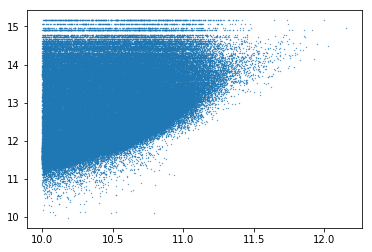

In [12]:
plt.scatter(np.log10(subhalos['stellar_mass']), np.log10(subhalos['Halo_mass_M_Mean200']*1E10), s =0.1)

In [13]:
S_pos = subhalos['SubhaloPos']
S_vel = subhalos['SubhaloVel']
S_vmax = subhalos['SubhaloVmax']
S_stellar_mass = subhalos['stellar_mass']
S_parent_fof = subhalos['Halo_mass_M_Mean200']
n_S = len(S_pos)
print(n_S)

149213


In [14]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S_pad_pos = S_pos.copy()
S_pad_vel = S_vel.copy()
S_pad_vmax = S_vmax.copy()
S_pad_stellar_mass = S_stellar_mass.copy()
S_pad_fof = S_parent_fof.copy()
S_pad_id = np.arange(n_S)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S_pad_pos = np.append(S_pad_pos, new_pos, axis=0)
                S_pad_vel = np.append(S_pad_vel, S_vel, axis=0)
                S_pad_vmax = np.append(S_pad_vmax, S_vmax)
                S_pad_stellar_mass = np.append(S_pad_stellar_mass, S_stellar_mass)
                S_pad_id = np.append(S_pad_id, np.arange(n_S))
                S_pad_fof = np.append(S_pad_fof, S_parent_fof)

In [15]:
nbrs_S = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S_pad_pos)
dist_S, ind_S = nbrs_S.kneighbors(S_pad_pos)
print(S_pad_pos.shape)
print(dist_S.shape)

(4028751, 3)
(4028751, 20)


In [46]:
neighbor_index = ind_S[:,1]
neighbor_list = ind_S[:,2:]
print(np.shape(neighbor_list))

n_pairs = 0

halo_A_id = np.empty((0), dtype=int)
halo_B_id = np.empty((0), dtype=int)

for i in range(n_S):
    l = neighbor_index[neighbor_index[i]]% n_S
    j = neighbor_index[i] % n_S
    
    other_j = neighbor_list[i,:] % n_S
    other_l = neighbor_list[neighbor_index[i],:] % n_S
    
    if((i==l) & (not (j in halo_A_id)) & (not (i in halo_B_id)) & (not (j in halo_B_id)) & (not (i in halo_A_id))): # first check to find mutual neighbors
        if((dist_S[i,1]/hubble > 100.0)): #check on the distance between the two galaxies
            stellar_mass_i = S_pad_stellar_mass[i]
            stellar_mass_j = S_pad_stellar_mass[j]
            mass_limit = min([stellar_mass_i, stellar_mass_j])
                
            pair_d = dist_S[i,1] # This is the current pair distance
            #dist_limit = pair_d * 4.5 # exclusion radius for massive structures
            dist_limit = max([3800.0, pair_d * 4.5])
            massive_close_to_i = any((dist_S[i,2:]<dist_limit) & (S_pad_stellar_mass[other_j] >= mass_limit))
            massive_close_to_j = any((dist_S[j,2:]<dist_limit) & (S_pad_stellar_mass[other_l] >= mass_limit))
            if((not massive_close_to_i) & (not massive_close_to_j)): # check on massive structures inside exclusion radius
                n_pairs = n_pairs+ 1
                if stellar_mass_i < stellar_mass_j:
                    halo_A_id = np.append(halo_A_id, int(i))
                    halo_B_id = np.append(halo_B_id, int(j))
                else:
                    halo_A_id = np.append(halo_A_id, int(j))
                    halo_B_id = np.append(halo_B_id, int(i))                    
                    #print(pair_d)
print(n_pairs)

(4028751, 18)
1241


In [47]:
filename = '../data/pairs_box_L205n2500TNG.hdf5'
print("Started writing data to ", filename)

h5f = h5py.File(filename, 'w')
h5f.create_dataset('pos_A', data=S_pos[halo_A_id,:]/hubble)
h5f.create_dataset('pos_B', data=S_pos[halo_B_id,:]/hubble)
h5f.create_dataset('pos_G', data=S_pos/hubble)
h5f.create_dataset('vel_A', data=S_vel[halo_A_id,:])
h5f.create_dataset('vel_B', data=S_vel[halo_B_id,:])
h5f.create_dataset('vel_G', data=S_vel)
h5f.create_dataset('vmax_A', data=S_vmax[halo_A_id])
h5f.create_dataset('vmax_B', data=S_vmax[halo_B_id])
h5f.create_dataset('vmax_G', data=S_vmax)
h5f.create_dataset('stellar_mass_A', data=S_stellar_mass[halo_A_id])
h5f.create_dataset('stellar_mass_B', data=S_stellar_mass[halo_B_id])
h5f.create_dataset('stellar_mass_G', data=S_stellar_mass)
h5f.create_dataset('halo_mass_A', data=S_parent_fof[halo_A_id]*1E10/hubble)
h5f.create_dataset('halo_mass_B', data=S_parent_fof[halo_B_id]*1E10/hubble)
h5f.create_dataset('halo_mass_G', data=S_parent_fof*1E10/hubble)
h5f.create_dataset('hubble', data=hubble)
h5f.close()

Started writing data to  ../data/pairs_box_L205n2500TNG.hdf5


In [31]:
# Referencia distancias a M31
# http://adsabs.harvard.edu/abs/2012ApJ...758...11C

# Referencia distancia Cen A
# http://adsabs.harvard.edu/abs/10.1071/AS09061
  
# Distance to M83
# http://adsabs.harvard.edu/abs/2003ApJ...590..256T